In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AffinityPropagation
from sklearn import metrics
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import itertools

In [2]:
# Boston Marathon data from 2012
raw2012 = pd.read_csv('~/Desktop/Data_Science/Boston_Marathon_2012.csv')

In [3]:
raw2012.head(10)

,division,name,city,gender,age,official,bib,overall,state,genderdiv,net,country
0,4 / 26,"Soejima, Masazumi",Fukuoka City,M,41,83.45,W1,4 / 35,NaN,4 / 26,83.45,JPN
1,14 / 4335,"Gebremariam, Gebregziabher",Tigray,M,27,142.93,2,14 / 21616,NaN,14 / 12621,142.93,ETH
2,6 / 26,"Van Dyk, Ernst F.",Paarl,M,39,84.38,W2,6 / 35,NaN,6 / 26,84.38,RSA
3,2 / 26,"Fearnley, Kurt H.",Hamilton,M,31,81.65,W3,2 / 35,NaN,2 / 26,81.65,AUS
4,3 / 26,"Hokinoue, Kota",Iizuka,M,38,83.43,W4,3 / 35,NaN,3 / 26,83.43,JPN
5,2 / 4335,"Matebo, Levy",Trans Nzoia,M,22,133.10,4,2 / 21616,NaN,2 / 12621,133.10,KEN
6,1 / 4599,"Cherop, Sharon",Marakwet,F,28,151.83,F4,28 / 21616,NaN,1 / 8995,151.83,KEN
7,5 / 4335,"Chebet, Wilson",Marakwet,M,26,134.93,5,5 / 21616,NaN,5 / 12621,134.93,KEN
8,1 / 26,"Cassidy, Joshua R.",Toronto,M,27,78.42,W5,1 / 35,ON,1 / 26,78.42,CAN
9,5 / 26,"Schabort, Krige",Cedartown,M,48,83.73,W6,5 / 35,GA,5 / 26,83.73,USA


In [4]:
raw2012.shape

(21652, 12)

In [5]:
raw2012.describe()

,age,net
count,21652.000000,21652.00000
mean,41.836135,258.64258
std,10.858308,49.94535
min,18.000000,78.42000
25%,33.000000,224.63000
50%,42.000000,251.07500
75%,50.000000,285.53000
max,83.000000,570.27000


In [6]:
raw2012['official'].value_counts()

-         76
239.08    10
266.43    10
238.55    10
232.00    10
248.20    10
243.47    10
266.25     9
275.18     9
260.77     9
237.90     9
238.68     9
233.30     9
236.23     9
237.43     9
245.33     8
244.03     8
238.10     8
257.03     8
259.55     8
221.97     8
233.88     8
239.93     8
224.90     8
232.12     8
263.87     8
252.07     8
270.78     8
234.97     8
256.00     8
          ..
293.43     1
415.00     1
308.72     1
176.32     1
158.37     1
412.73     1
384.40     1
171.02     1
161.40     1
287.20     1
287.47     1
274.30     1
307.47     1
298.52     1
316.52     1
242.35     1
281.72     1
227.58     1
165.45     1
172.62     1
324.87     1
387.68     1
250.02     1
211.25     1
299.97     1
352.85     1
388.23     1
185.07     1
170.07     1
428.43     1
Name: official, Length: 9570, dtype: int64

In [7]:
raw2012.loc[raw2012['official'].str.contains("-"),'official'] = 0

raw2012['official'] = raw2012['official'].astype(np.float64)

In [8]:
#separate division column to two numerical columns
raw2012['div_rank'], raw2012['div'] = raw2012['division'].str.split(' / ', 1).str
raw2012['div_rank'] = raw2012['div_rank'].astype(np.float64)
raw2012['div'] = raw2012['div'].astype(np.float64)

In [9]:
#separate genderdiv column to two numerical columns
raw2012['gender_rank'], raw2012['gender_division'] = raw2012['genderdiv'].str.split(' / ', 1).str
raw2012['gender_rank'] = raw2012['gender_rank'].astype(np.float64)
raw2012['gender_division'] = raw2012['gender_division'].astype(np.float64)

In [10]:
raw2012.describe()

,age,official,net,div_rank,div,gender_rank,gender_division
count,21652.000000,21652.000000,21652.00000,21652.000000,21652.000000,21652.000000,21652.000000
mean,41.836135,261.875575,258.64258,1376.575790,2752.150748,5547.342324,11093.683817
std,10.858308,52.641530,49.94535,1182.365162,1516.672306,3374.529805,1842.143331
min,18.000000,0.000000,78.42000,1.000000,1.000000,1.000000,9.000000
25%,33.000000,228.377500,224.63000,439.000000,1521.000000,2689.000000,8995.000000
50%,42.000000,255.475000,251.07500,1039.000000,2255.000000,5395.500000,12621.000000
75%,50.000000,290.372500,285.53000,1949.000000,4335.000000,8102.000000,12621.000000
max,83.000000,475.320000,570.27000,4599.000000,4599.000000,12621.000000,12621.000000


In [11]:
raw2012['city'].value_counts()

Boston                           500
New York                         428
Cambridge                        191
Chicago                          175
Toronto                          174
Austin                           156
Arlington                        143
Somerville                       139
Washington                       134
San Diego                        127
Brookline                        124
Seoul                            116
Brooklyn                         114
Seattle                          106
London                           105
San Francisco                    105
Calgary                          103
Portland                         103
Houston                          103
Brighton                         101
Newton                           101
Rochester                         90
Dallas                            86
Ottawa                            86
Denver                            77
Philadelphia                      75
South Boston                      72
C

In [12]:
raw2012 = pd.get_dummies(raw2012, columns=['gender', 'state', 'country'])

In [13]:
raw2012.describe()

,age,official,net,div_rank,div,gender_rank,gender_division,gender_F,gender_M,state_AA,...,country_RUS,country_SIN,country_SLO,country_SUI,country_SVK,country_SWE,country_UAE,country_URU,country_USA,country_VEN
count,21652.000000,21652.000000,21652.00000,21652.000000,21652.000000,21652.000000,21652.000000,21652.000000,21652.000000,21652.000000,...,21652.000000,21652.000000,21652.000000,21652.000000,21652.000000,21652.000000,21652.000000,21652.000000,21652.000000,21652.000000
mean,41.836135,261.875575,258.64258,1376.575790,2752.150748,5547.342324,11093.683817,0.415851,0.584149,0.000046,...,0.000323,0.000600,0.000323,0.002125,0.000046,0.001478,0.000139,0.000231,0.834288,0.000554
std,10.858308,52.641530,49.94535,1182.365162,1516.672306,3374.529805,1842.143331,0.492879,0.492879,0.006796,...,0.017978,0.024496,0.017978,0.046045,0.006796,0.038416,0.011770,0.015195,0.371831,0.023536
min,18.000000,0.000000,78.42000,1.000000,1.000000,1.000000,9.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,33.000000,228.377500,224.63000,439.000000,1521.000000,2689.000000,8995.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,42.000000,255.475000,251.07500,1039.000000,2255.000000,5395.500000,12621.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,50.000000,290.372500,285.53000,1949.000000,4335.000000,8102.000000,12621.000000,1.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,83.000000,475.320000,570.27000,4599.000000,4599.000000,12621.000000,12621.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Defining Data

In [51]:
list(X)

['age',
 'official',
 'net',
 'div_rank',
 'div',
 'gender_rank',
 'gender_division',
 'gender_F',
 'gender_M',
 'state_AA',
 'state_AB',
 'state_AE',
 'state_AK',
 'state_AL',
 'state_AP',
 'state_AR',
 'state_AZ',
 'state_BC',
 'state_CA',
 'state_CO',
 'state_CT',
 'state_DC',
 'state_DE',
 'state_FL',
 'state_GA',
 'state_HI',
 'state_IA',
 'state_ID',
 'state_IL',
 'state_IN',
 'state_KS',
 'state_KY',
 'state_LA',
 'state_MA',
 'state_MB',
 'state_MD',
 'state_ME',
 'state_MI',
 'state_MN',
 'state_MO',
 'state_MS',
 'state_MT',
 'state_NB',
 'state_NC',
 'state_ND',
 'state_NE',
 'state_NH',
 'state_NJ',
 'state_NL',
 'state_NM',
 'state_NS',
 'state_NT',
 'state_NV',
 'state_NY',
 'state_OH',
 'state_OK',
 'state_ON',
 'state_OR',
 'state_PA',
 'state_PE',
 'state_PR',
 'state_QC',
 'state_RI',
 'state_SC',
 'state_SD',
 'state_SK',
 'state_TN',
 'state_TX',
 'state_UT',
 'state_VA',
 'state_VT',
 'state_WA',
 'state_WI',
 'state_WV',
 'state_WY',
 'state_YT',
 'country_ARG',
 

In [15]:
X = raw2012.drop(['division', 'name', 'city', 'bib', 'overall', 'genderdiv',], 1)

X_norm = normalize(X)

## K-Means

### Elbow Plot

In [ ]:
# determine k using elbow method

from scipy.spatial.distance import cdist

# k means determine k
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(X_norm)
    kmeanModel.fit(X_norm)
    distortions.append(sum(np.min(cdist(X_norm, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X_norm.shape[0])

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

Comparing results of clustering (using default settings) with K-Mean and Mini_Batch K-Means

In [41]:
# k-means using default settings
y_pred = KMeans().fit_predict(X_norm)

In [42]:
# mini-batch k-means with default settings
mini_y_pred = MiniBatchKMeans().fit_predict(X_norm)

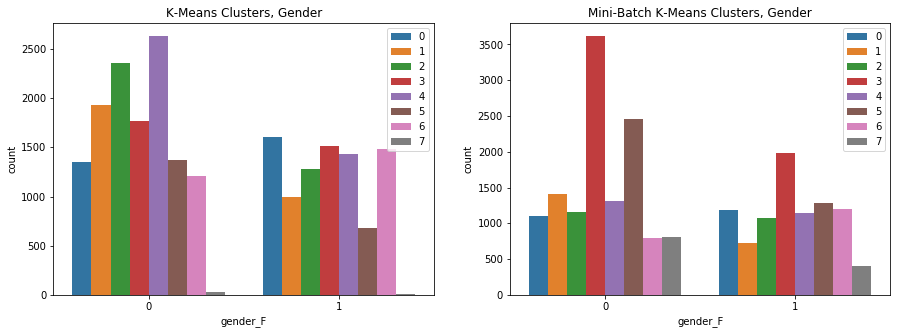

In [43]:
# Visualize clusters with binary feature of gender

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
sns.countplot(x="gender_F", hue=y_pred, data=raw2012)
plt.title('K-Means Clusters, Gender')

plt.subplot(1, 2, 2)
sns.countplot(x="gender_F", hue=mini_y_pred, data=raw2012)
plt.title('Mini-Batch K-Means Clusters, Gender')

plt.show()

Using the default of 8 clusters results in variation between the two methods.

Try comparing both methods with 3 clusters.

In [44]:
# k-means with 3 clusters
y_pred = KMeans(n_clusters=3).fit_predict(X_norm)

In [45]:
# mini-batch k-means with 3 clusters
mini_y_pred = MiniBatchKMeans(n_clusters=3).fit_predict(X_norm)

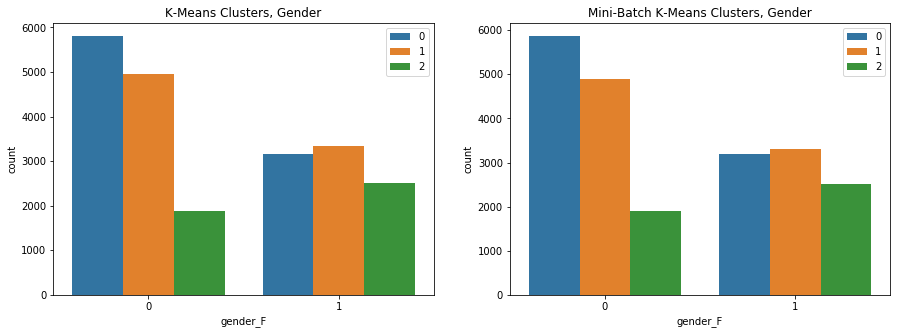

In [46]:
# Visualize clusters with binary feature of gender

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
sns.countplot(x="gender_F", hue=y_pred, data=raw2012)
plt.title('K-Means Clusters, Gender')

plt.subplot(1, 2, 2)
sns.countplot(x="gender_F", hue=mini_y_pred, data=raw2012)
plt.title('Mini-Batch K-Means Clusters, Gender')

plt.show()

This shows better consistency between the two k-means methods.

Looking at the results, we find that significantly more men are in groups 0 and 1, with the smallest group (2) being comprised of more women than men.

Let's look at another feature.

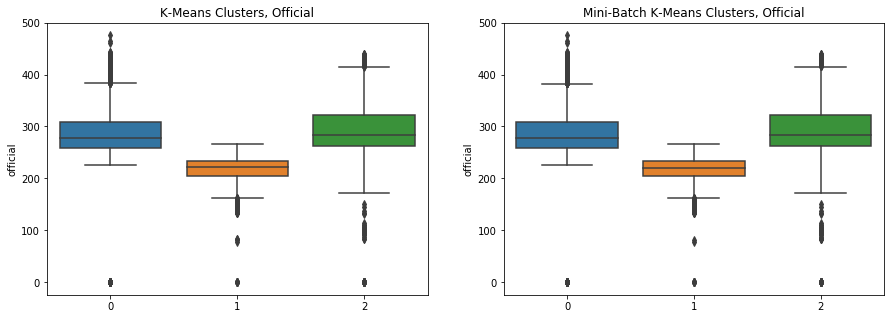

In [49]:
# Visualize clusters with binary feature of gender

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
sns.boxplot(y="official", x=y_pred, data=raw2012)
plt.title('K-Means Clusters, Official')

plt.subplot(1, 2, 2)
sns.boxplot(y="official", x=mini_y_pred, data=raw2012)
plt.title('Mini-Batch K-Means Clusters, Official')

plt.show()

Exploring the Official variable values for each cluster, we see that the second cluster (group 1) has the lowest times, while the first and third clusters (groups 0 and 2) have similar values.

## Mean Shift

In [52]:
ms = MeanShift(bin_seeding=True)
ms.fit(X_norm)

# Extract cluster assignments for each data point.
labels = ms.labels_

# Coordinates of the cluster centers.
cluster_centers = ms.cluster_centers_

# Count our clusters.
n_clusters_ = len(np.unique(labels))

print("Number of estimated clusters: {}".format(n_clusters_))

Number of estimated clusters: 2


Mean shift proposes 2 clusters for the data.

In [53]:
predict=ms.fit_predict(X_norm)

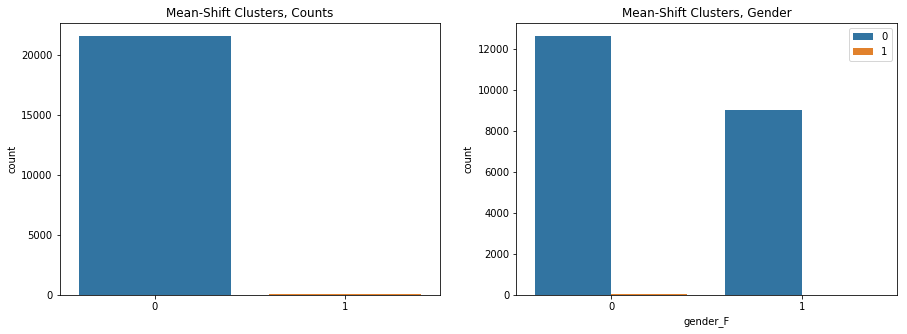

In [55]:
# Visualize clusters with binary feature of gender

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
sns.countplot(x=predict, data=raw2012)
plt.title('Mean-Shift Clusters, Counts')

plt.subplot(1, 2, 2)
sns.countplot(x="gender_F", hue=predict, data=raw2012)
plt.title('Mean-Shift Clusters, Gender')

plt.show()

Mean shift has generated one very large cluster and one very small cluster.  This doesn't seem like it will be very insightful.

Let's try another method and go back to three clusters

## Spectral Clustering

In [ ]:
# Spectral Clustering

sc = SpectralClustering(n_clusters=3)
sc.fit(X_norm)

#Predicted clusters.
sc_predict=sc.fit_predict(X_norm)